In [2]:
import sys
import os
import pandas as pd
import heist
import helpers
import torch.distributions
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
from procgen import ProcgenGym3Env
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_impala import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv
import seaborn as sns


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
layers = {
    1: 'conv1a',
    2: 'pool1',
    3: 'conv2a',
    4: 'conv2b',
    5: 'pool2',
    6: 'conv3a',
    7: 'pool3',
    8: 'conv4a',
    9: 'pool4',
    10: 'fc1',
    11: 'fc2',
    12: 'fc3',
    13: 'value_fc',
    14: 'dropout_conv',
    15: 'dropout_fc'
}



In [4]:
model = helpers.load_interpretable_model(model_path="../model_interpretable.pt")

save_gif_option = True  
for episode in range(20):
    venv = heist.create_venv(1,0,1000000)
    total_reward, frames, observations = helpers.run_episode_and_save_as_gif(venv, model, filepath=f'episode_{episode}.gif', save_gif=save_gif_option, is_procgen_env=True)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")

building procgen...

/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


done
Episode 1 finished with total reward: [10.]
Episode 2 finished with total reward: [10.]
Episode 3 finished with total reward: [10.]
Episode 4 finished with total reward: [10.]
Episode 5 finished with total reward: [10.]
Episode 6 finished with total reward: [10.]
Episode 7 finished with total reward: [10.]
Episode 8 finished with total reward: [10.]
Episode 9 finished with total reward: [10.]
Episode 10 finished with total reward: [10.]
Episode 11 finished with total reward: [10.]
Episode 12 finished with total reward: [10.]
Episode 13 finished with total reward: [10.]
Episode 14 finished with total reward: [10.]
Episode 15 finished with total reward: [10.]
Episode 16 finished with total reward: [10.]
Episode 17 finished with total reward: [10.]
Episode 18 finished with total reward: [10.]
Episode 19 finished with total reward: [10.]
Episode 20 finished with total reward: [10.]


In [5]:
def identify_entity_region(entity_position):
    """
    Identify which region an entity is in, based on a 9x9 grid.
    
    Args:
    entity_position (tuple): A tuple (x, y) representing the entity's position,
                             where x and y are between 0 and 8.9.
    
    Returns:
    dict: A dictionary containing the region number, row, and column.
    """
    x, y = entity_position
    
    # Calculate the region row and column (0-indexed)
    region_col = int(0 if math.isnan(x) else x)
    region_row = 8 - int(0 if math.isnan(y) else y)  # Invert y-axis so higher values are higher on the grid
    
    # Ensure the values are within the correct range
    region_row = min(max(region_row, 0), 8)
    region_col = min(max(region_col, 0), 8)
    
    # Calculate the region number (1-indexed)
    region_number = (region_row) * 9 + region_col + 1
    
    return {
        'region_number': region_number,
        'region_row': region_row,
        'region_col': region_col
    }

def get_entity_regions(state):
    """
    Extract all entities from the environment and identify their regions.
    
    Args:
    state: The game state object from heist.py
    
    Returns:
    dict: A dictionary mapping entity types to their positions and regions.
    """
    entities = state.state_vals["ents"]
    entity_regions = {}
    
    # Initialize 9x9 grid
    grid = [[[] for _ in range(9)] for _ in range(9)]
    
    for entity in entities:
        entity_type = entity["image_type"].val
        x = entity["x"].val
        y = entity["y"].val 
        
        # Map image_type values to entity names
        entity_name = {
            9: "gem",
            2: "key",
            2: "key",
            2: "key",
            1: "lock",
            1: "lock",
            1: "lock",
            0: "player",
            51: "wall"

        }.get(entity_type, f"unknown_{entity_type}")
        
        region_info = identify_entity_region((x, y))
        
        if entity_name not in entity_regions:
            entity_regions[entity_name] = []
        
        entity_regions[entity_name].append({
            'position': (x, y),
            'region': region_info
        })
        
        # Add entity to the corresponding cell in the 9x9 grid
        grid[region_info['region_row']][region_info['region_col']].append(entity_name)
    
    return entity_regions, grid

# Example usage:
# Assuming you have a state object from heist.py
state = heist.state_from_venv(venv, 0)
entity_regions, grid = get_entity_regions(state)

# Print object types and regions for each entity
for entity_type, entities in entity_regions.items():
    for entity in entities:
        print(f"Object Type: {entity_type}")
        print(f"Region: {entity['region']['region_number']}")
        print(f"Region Row: {entity['region']['region_row']}")
        print(f"Region Column: {entity['region']['region_col']}")
        print(f"Position: {entity['position']}")
        print("---")
print("Entity Regions:", entity_regions)
print("9x9 Grid:")
for row in grid:  # Print rows in order, with higher y values at the top
    print(row)


Object Type: player
Region: 66
Region Row: 7
Region Column: 2
Position: (2.5, 1.5)
---
Object Type: gem
Region: 20
Region Row: 2
Region Column: 1
Position: (1.5235307216644287, 6.422500133514404)
---
Object Type: key
Region: 58
Region Row: 6
Region Column: 3
Position: (3.6056606769561768, 2.5875725746154785)
---
Object Type: key
Region: 42
Region Row: 4
Region Column: 5
Position: (5.568855285644531, 4.576450824737549)
---
Object Type: key
Region: 73
Region Row: 8
Region Column: 0
Position: (0.9624999761581421, 0.022499999031424522)
---
Object Type: key
Region: 73
Region Row: 8
Region Column: 0
Position: (0.9024999737739563, 0.022499999031424522)
---
Object Type: lock
Region: 59
Region Row: 6
Region Column: 4
Position: (4.5, 2.5)
---
Object Type: lock
Region: 25
Region Row: 2
Region Column: 6
Position: (6.5, 6.5)
---
Entity Regions: {'player': [{'position': (2.5, 1.5), 'region': {'region_number': 66, 'region_row': 7, 'region_col': 2}}], 'gem': [{'position': (1.5235307216644287, 6.422500

In [8]:
import numpy as np

def find_most_active_region(activation_data):
    # Ensure the data is a numpy array
    activation_data = np.array(activation_data)
    
    # Ensure the data is in the expected shape (32, 32)
    if activation_data.shape != (32, 32):
        raise ValueError(f"Activation data should be a 32x32 grid, but got shape {activation_data.shape}")
    
    # Create a 9x9 grid to store region sums
    region_sums = np.zeros((9, 9))
    
    # Calculate the size of each region
    region_size = 32 / 9
    
    # Sum the activations in each region
    for i in range(9):
        for j in range(9):
            start_x = int(i * region_size)
            end_x = int((i + 1) * region_size)
            start_y = int(j * region_size)
            end_y = int((j + 1) * region_size)
            
            region_sums[i, j] = np.sum(activation_data[start_x:end_x, start_y:end_y])
    
    # Find the indices of the maximum sum
    max_index = np.unravel_index(np.argmax(region_sums), region_sums.shape)
    
    # Calculate the region number (1 to 81)
    region_number = max_index[0] * 9 + max_index[1] + 1
    
    return {
        'region_number': region_number,
        'region_row': max_index[0],
        'region_col': max_index[1],
        'activation_sum': region_sums[max_index]
    }

def analyze_all_filters(normal_activations, layer_number):

    pool1_activations = normal_activations[layers[layer_number]][0]
    
    results = []
    for i in range(pool1_activations.shape[0]):  # Iterate over all filters
        filter_data = pool1_activations[i]
        result = find_most_active_region(filter_data)
        result['filter_number'] = i + 1  # Adding filter number to the result
        results.append(result)
    
    return results



In [11]:
def match_activations_with_entities(filter_results, entity_regions):
    matches = []
    
    for filter_result in filter_results:
        filter_number = filter_result['filter_number']
        filter_region = filter_result['region_number']
        
        for entity_type, entities in entity_regions.items():
            for entity in entities:
                if entity['region']['region_number'] == filter_region:
                    matches.append({
                        'filter_number': filter_number,
                        'region_number': filter_region,
                        'entity_type': entity_type,
                        'entity_position': entity['position']
                    })
    
    return matches



venv = heist.create_venv(1,random.randint(0,10000),1)
observation = venv.reset()
observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

model_activations = helpers.ModelActivations(model)

output1, normal_activations = model_activations.run_with_cache(helpers.observation_to_rgb(observation), layers.values())


# Example usage:
filter_results = analyze_all_filters(normal_activations, 4)
entity_regions, _ = get_entity_regions(state)

matches = match_activations_with_entities(filter_results, entity_regions)

print("Matches between filter activations and entity regions:")
for match in matches:
    print(f"Filter {match['filter_number']} {match['entity_type']}")

AssertionError: 

In [12]:
import pandas as pd
from collections import defaultdict

num_iterations = 1000
match_histogram = defaultdict(lambda: defaultdict(int))

for _ in range(num_iterations):
    venv = heist.create_venv(1, random.randint(0, 10000), 1)
    observation = venv.reset()

    model_activations = helpers.ModelActivations(model)
    output1, normal_activations = model_activations.run_with_cache(helpers.observation_to_rgb(observation), layers.values())
    
    filter_results = analyze_all_filters(normal_activations,4)
    entity_regions, _ = get_entity_regions(state)

    matches = match_activations_with_entities(filter_results, entity_regions)

    for match in matches:
        match_histogram[match['filter_number']][match['entity_type']] += 1



Histogram of matches between filter activations and entity regions:
Entity Type      key   lock   gem  player
Filter Number                            
1               40.0   18.0   7.0    34.0
2               46.0   38.0  12.0    13.0
3               18.0   22.0   1.0    23.0
4               39.0   72.0   7.0     7.0
5               24.0   47.0  11.0     3.0
6              139.0   61.0   1.0     1.0
7               74.0   37.0  20.0     1.0
8               66.0   42.0   7.0    18.0
9              161.0   66.0   2.0    24.0
10              51.0   69.0  15.0     6.0
11              62.0   36.0  11.0     7.0
12              93.0   27.0  31.0     1.0
13               2.0    0.0   0.0     0.0
14              62.0   65.0  11.0    22.0
15              26.0   44.0   3.0    18.0
16             138.0    2.0   0.0    15.0
17              81.0   20.0  15.0    15.0
18              25.0   61.0  12.0    16.0
19              30.0   35.0  10.0    31.0
20             148.0   56.0  12.0     0.0
21      

<Figure size 1200x800 with 0 Axes>

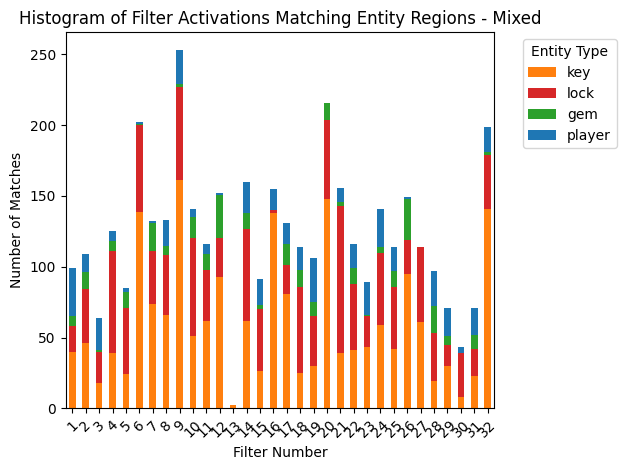

In [14]:
# Convert the nested dictionary to a DataFrame
df = pd.DataFrame(match_histogram).T.fillna(0)
df.index = pd.to_numeric(df.index)  # Convert index to numeric
df = df.sort_index()  # Sort by index (filter number)
df.index.name = 'Filter Number'
df.columns.name = 'Entity Type'

print("Histogram of matches between filter activations and entity regions:")
print(df)
color_scheme = {
    'player': '#1f77b4',  # blue
    'gem': '#2ca02c',     # green
    'key': '#ff7f0e',     # orange
    'lock': '#d62728',    # red
    'wall': '#8c564b'     # brown
}

plt.figure(figsize=(12, 8))
df.plot(kind='bar', stacked=True, color=[color_scheme.get(col, '#999999') for col in df.columns])
plt.title(f'Histogram of Filter Activations Matching Entity Regions - Mixed')
plt.xlabel('Filter Number')
plt.ylabel('Number of Matches')
plt.legend(title='Entity Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(len(df.index)), df.index, rotation=45)  
plt.tight_layout()

if plt.gcf().get_axes():
    plt.savefig('filter_activations_entity_matches_histogram.png', bbox_inches='tight')
    print("Figure saved as 'filter_activations_entity_matches_histogram.png'")
else:
    print("Warning: The figure is empty. No image was saved.")

plt.show()
plt.close() 


In [ ]:



import pandas as pd
from collections import defaultdict

num_iterations = 1000
match_histogram = defaultdict(lambda: defaultdict(int))


classified_dataset = heist.create_classified_dataset(num_samples_per_category=4, num_levels=0)
# Combine examples from all categories into one big list
combined_dataset = []

for category, examples in classified_dataset.items():
    combined_dataset.extend(examples)


for sample in combined_dataset:
    venv = heist.create_venv(1, random.randint(0, 10000), 1)
    observation = venv.reset()

    model_activations = helpers.ModelActivations(model)
    output1, normal_activations = model_activations.run_with_cache(helpers.observation_to_rgb(observation), layers.values())

    filter_results = analyze_all_filters(normal_activations)
    state = heist.state_from_venv(venv, 0) 
    entity_regions, _ = get_entity_regions(state)

    matches = match_activations_with_entities(filter_results, entity_regions)

    for match in matches:
        match_histogram[match['filter_number']][match['entity_type']] += 1



In [27]:
classified_dataset = heist.create_classified_dataset(num_samples_per_category=4, num_levels=0)
# Combine examples from all categories into one big list
combined_dataset = []

for category, examples in classified_dataset.items():
    combined_dataset.extend(examples)

# Print the shape of the combined dataset
print(f"Combined dataset shape: {np.array(combined_dataset).shape}")


Combined dataset shape: (28, 64, 64, 3)


In [26]:
print(classified_dataset.values())
    

dict_values([[array([[[0.16470588, 0.39607843, 0.60392157],
        [0.20392157, 0.48235294, 0.74117647],
        [0.16470588, 0.39215686, 0.59607843],
        ...,
        [0.77254902, 0.81960784, 0.82352941],
        [0.73333333, 0.79607843, 0.8       ],
        [0.73333333, 0.79607843, 0.8       ]],

       [[0.16078431, 0.41960784, 0.63921569],
        [0.14117647, 0.37647059, 0.57254902],
        [0.1372549 , 0.36862745, 0.57254902],
        ...,
        [0.69411765, 0.75294118, 0.75686275],
        [0.69411765, 0.75294118, 0.75686275],
        [0.69411765, 0.75294118, 0.75686275]],

       [[0.11764706, 0.3372549 , 0.52941176],
        [0.11764706, 0.3372549 , 0.5372549 ],
        [0.11764706, 0.36862745, 0.58039216],
        ...,
        [0.69411765, 0.75294118, 0.75686275],
        [0.73333333, 0.79607843, 0.8       ],
        [0.73333333, 0.79607843, 0.8       ]],

       ...,

       [[0.69411765, 0.75294118, 0.75686275],
        [0.69411765, 0.75294118, 0.75686275],
        

In [19]:
combined_dataset

{'gem': array([[[0.16470588, 0.39607843, 0.60392157],
         [0.20392157, 0.48235294, 0.74117647],
         [0.16470588, 0.39215686, 0.59607843],
         ...,
         [0.77254902, 0.81960784, 0.82352941],
         [0.73333333, 0.79607843, 0.8       ],
         [0.73333333, 0.79607843, 0.8       ]],
 
        [[0.16078431, 0.41960784, 0.63921569],
         [0.14117647, 0.37647059, 0.57254902],
         [0.1372549 , 0.36862745, 0.57254902],
         ...,
         [0.69411765, 0.75294118, 0.75686275],
         [0.69411765, 0.75294118, 0.75686275],
         [0.69411765, 0.75294118, 0.75686275]],
 
        [[0.11764706, 0.3372549 , 0.52941176],
         [0.11764706, 0.3372549 , 0.5372549 ],
         [0.11764706, 0.36862745, 0.58039216],
         ...,
         [0.69411765, 0.75294118, 0.75686275],
         [0.73333333, 0.79607843, 0.8       ],
         [0.73333333, 0.79607843, 0.8       ]],
 
        ...,
 
        [[0.69411765, 0.75294118, 0.75686275],
         [0.69411765, 0.75294118, 

In [17]:
classified_dataset

{'gem': [array([[[0.73333333, 0.79607843, 0.8       ],
          [0.73333333, 0.79607843, 0.8       ],
          [0.77254902, 0.81960784, 0.82352941],
          ...,
          [0.77254902, 0.81960784, 0.82352941],
          [0.73333333, 0.79607843, 0.8       ],
          [0.73333333, 0.79607843, 0.8       ]],
  
         [[0.69411765, 0.75294118, 0.75686275],
          [0.69411765, 0.75294118, 0.75686275],
          [0.69411765, 0.75294118, 0.75686275],
          ...,
          [0.69411765, 0.75294118, 0.75686275],
          [0.69411765, 0.75294118, 0.75686275],
          [0.69411765, 0.75294118, 0.75686275]],
  
         [[0.73333333, 0.79607843, 0.8       ],
          [0.73333333, 0.79607843, 0.8       ],
          [0.69411765, 0.75294118, 0.75686275],
          ...,
          [0.69411765, 0.75294118, 0.75686275],
          [0.73333333, 0.79607843, 0.8       ],
          [0.73333333, 0.79607843, 0.8       ]],
  
         ...,
  
         [[0.69411765, 0.75294118, 0.75686275],
       